In [1]:
import os
import json
import torch
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
from typing import List
import multiprocessing as mp
import torch.nn.functional as F
from collections import defaultdict
from random import sample, random, seed
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
set_seed = 42
torch.manual_seed(set_seed)
torch.cuda.manual_seed(set_seed)
torch.cuda.manual_seed_all(set_seed)
np.random.seed(set_seed)
seed(set_seed)

In [3]:
DIM = 50
MARGIN = 1
BATCH_SIZE = 512
TOP_K = 5
CORRUPTED_NUM = 100
NORM = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
with open('./data/darpa_datasets/data/recording_by_lab/benign.json','rb') as f:
    benign = json.load(f)
    benign = benign['benign']
with open('./data/darpa_datasets/data/recording_by_lab/CALDERA_malicious.json','rb') as f:
    malicious = json.load(f)

In [5]:
'''
object_'s key should not be in ['type','pid','srcip', 'srcport', 'protocol', 'type'], 英仁說的
values of object_:'dstip' and object_:'dstport' should be concatenated, 英仁說的
I choose cmdline from subject's keys and object_'s keys, so image is removed from object_.
'''

'''
wating to fixed bugs.
benign[i][subject]['cmdline'] or benign[i][relation] can be None. [Checking againg, when fixed the bugs.]

'''


temp = []
filter_ls = ['type','image','pid','srcip', 'srcport', 'protocol', 'type']
for i,(subject,relation,object_) in tqdm(enumerate(benign),total=len(benign)):
    if benign[i][subject]['cmdline'] != None and benign[i][relation] != None:
        filtered_object = list(filter(lambda x: x[0] not in filter_ls,benign[i][object_].items()))
        object_data = ':'.join([str(y) for x,y in filtered_object])
        temp.append([
            benign[i][subject]['cmdline'], benign[i][relation], object_data, 'benign'
        ])

100%|██████████| 70084/70084 [00:00<00:00, 1478342.39it/s]


In [6]:

'''
wating to fixed bugs.
benign[i][subject]['cmdline'] or benign[i][relation] can be None. [Checking againg, when fixed the bugs.]
'''

filter_ls = ['type','image','pid','srcip', 'srcport', 'protocol', 'type']
for key,values in tqdm(malicious.items(),total=len(malicious.items())):
    for value in values:
        for i,(subject,relation,object_) in enumerate(value['audit log']):
            if value['audit log'][i][subject]['cmdline'] != None and value['audit log'][i][relation] != None:
                filtered_object = list(filter(lambda x: x[0] not in filter_ls,benign[i][object_].items()))
                object_data = ':'.join([str(y) for x,y in filtered_object])
                temp.append([
                    value['audit log'][i][subject]['cmdline'], value['audit log'][i][relation], object_data, value['TTP']
                ])

100%|██████████| 69/69 [00:00<00:00, 11601.34it/s]


In [7]:
df = pd.DataFrame(temp,columns=['Subject','relation','Object','malicious_or_benign'])
train_df, valid_df = train_test_split(df, test_size=0.2,random_state=42,shuffle=True)
valid_df, test_df = train_test_split(valid_df, test_size=0.5,random_state=42,shuffle=True)

In [8]:
# df = pd.read_csv('./transE_data.csv')
# with open('./data/freebase_mtr100_mte100-train.txt','r') as f:
#     temp = np.array([i.split() for i in f.readlines()])
#     train_df = pd.DataFrame(temp,columns=['Subject','relation','Object'])
# with open('./data/freebase_mtr100_mte100-valid.txt','r') as f:
#     temp = np.array([i.split() for i in f.readlines()])
#     valid_df = pd.DataFrame(temp,columns=['Subject','relation','Object'])
# with open('./data/freebase_mtr100_mte100-test.txt','r') as f:
#     temp = np.array([i.split() for i in f.readlines()])
#     test_df = pd.DataFrame(temp,columns=['Subject','relation','Object'])

In [8]:
data = list(set(train_df['Subject']) | set(train_df['Object']))
subj_obj_dic = dict(zip(data,range(len(data))))
data = list(set(train_df['relation']))
relation_dic = dict(zip(data,range(len(data))))

In [9]:
print(len(subj_obj_dic))

355


In [10]:
train_df['Subject'] = train_df['Subject'].map(lambda x: subj_obj_dic.get(x,len(subj_obj_dic)))
train_df['Object'] = train_df['Object'].map(lambda x: subj_obj_dic.get(x,len(subj_obj_dic)))
train_df['relation'] = train_df['relation'].map(lambda x: relation_dic.get(x,len(relation_dic)))

valid_df['Subject'] = valid_df['Subject'].map(lambda x: subj_obj_dic.get(x,len(subj_obj_dic)))
valid_df['Object'] = valid_df['Object'].map(lambda x: subj_obj_dic.get(x,len(subj_obj_dic)))
valid_df['relation'] = valid_df['relation'].map(lambda x: relation_dic.get(x,len(relation_dic)))

test_df['Subject'] = test_df['Subject'].map(lambda x: subj_obj_dic.get(x,len(subj_obj_dic)))
test_df['Object'] = test_df['Object'].map(lambda x: subj_obj_dic.get(x,len(subj_obj_dic)))
test_df['relation'] = test_df['relation'].map(lambda x: relation_dic.get(x,len(relation_dic)))

/workdir/security/home/junjiehuang2468/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/workdir/security/home/junjiehuang2468/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/workdir/security/home/junjiehuang2468/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [11]:
class TransE_Model(nn.Module):
    def __init__(self,entity_num:int,relation_num:int,embedding_dim:int,NORM:int=1):
        super().__init__()
        self.NORM = NORM
        self.entity_num = entity_num
        self.relation_num = relation_num
        self.embedding_dim = embedding_dim
        self.entity_embedding = self.generate_embedding(self.entity_num)
        self.relation_embedding = self.generate_embedding(self.relation_num)
        self.relation_embedding = self.normalize_embedding(self.relation_embedding)
    
    def generate_embedding(self,num):
        emb = nn.Embedding(num_embeddings=num+1,embedding_dim=self.embedding_dim,padding_idx=num)
        emb.weight.data.uniform_(-6/(self.embedding_dim**0.5),6/(self.embedding_dim**0.5))
        return emb
    
    def normalize_embedding(self,emb):
        emb.weight.data /= emb.weight.data.norm(p=self.NORM,dim=1,keepdim=True)
        return emb
    
    def forward(self,subject,relation,object_):
        x = self.entity_embedding(subject)
        x += self.relation_embedding(relation)
        x -= self.entity_embedding(object_)
        return x.norm(p=self.NORM,dim=1)

In [12]:
class Custom_Dataset(Dataset):
    def __init__(self,df:pd.DataFrame):
        super().__init__()
        self.data = [tuple(i) for i in df.values]
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]

class Generate_Corrupted_Triple():
    def __init__(self,df:pd.DataFrame):
        self.obj = set(df['Object'])
        self.subj = set(df['Subject'])
        self.s_2_o_dic, self.o_2_s_dic = self.generate_dic(df)
    def generate_dic(self,df):
        s_2_o_dic = defaultdict(set)
        o_2_s_dic = defaultdict(set)
        for s,r,o,b_or_m in df.values:
            s_2_o_dic[s].add(o)
            o_2_s_dic[o].add(s)
        return s_2_o_dic,o_2_s_dic
    def __call__(self,subject,relation,object_):
        new_subject = torch.tensor([sample(self.subj - self.o_2_s_dic[obj],k=1)[0] for obj in object_.cpu().numpy()])
        new_object = torch.tensor([sample(self.obj - self.s_2_o_dic[subj],k=1)[0] for subj in subject.cpu().numpy()])
        return [new_subject,relation,object_],[subject,relation,new_object]
    
class Generate_Corrupted_Triple():
    def __init__(self,df:pd.DataFrame):
        self.obj_dic, self.subj_dic = self.generate_dic(df)
    def generate_dic(self,df):
        obj = set(df['Object'])
        subj = set(df['Subject'])
        subj_dic = defaultdict(set)
        obj_dic = defaultdict(set)
        s_2_o_dic = defaultdict(set)
        o_2_s_dic = defaultdict(set)
        for s,r,o,b_or_m in df.values:
            s_2_o_dic[s].add(o)
            o_2_s_dic[o].add(s)
        for key,value in o_2_s_dic.items():
            obj_dic[key] = subj - value
        for key,value in s_2_o_dic.items():
            subj_dic[key] = obj - value
        return obj_dic,subj_dic
    def __call__(self,subject,relation,object_):
        new_subject = torch.tensor([sample(self.obj_dic[obj], k=1)[0] for obj in object_.cpu().numpy()])
        new_object = torch.tensor([sample(self.subj_dic[subj], k=1)[0] for subj in subject.cpu().numpy()])
        return [new_subject,relation,object_],[subject,relation,new_object]

In [13]:
def To_Device(batch,device):
    return [b.to(device) for b in batch]

In [14]:
model = TransE_Model(
    entity_num=len(set(train_df['Subject']) | set(train_df['Object'])),
    relation_num=len(set(train_df['relation'])),
    embedding_dim=DIM,NORM=NORM
).to(device)
optim_fn = torch.optim.Adam(model.parameters())
loss_fn = nn.MarginRankingLoss(margin=MARGIN).to(device)
GCT = Generate_Corrupted_Triple(train_df)

In [15]:
# train, test = train_test_split(df, test_size=0.2)
train_dataset = Custom_Dataset(train_df)
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
valid_dataset = Custom_Dataset(valid_df)
valid_dataloader = DataLoader(valid_dataset,batch_size=16,shuffle=False)
test_dataset = Custom_Dataset(test_df)
test_dataloader = DataLoader(test_dataset,batch_size=len(test_dataset),shuffle=False)

In [16]:
def train(model,train_dataloader,loss_fn,optim_fn,device):
    losses = []
    bar = tqdm(enumerate(train_dataloader),total=len(train_dataloader))
    target = torch.tensor([-1], dtype=torch.long, device=device)
    for idx,batch in bar: 
        model.entity_embedding = model.normalize_embedding(model.entity_embedding)
        corrupted_batch_1,corrupted_batch_2 = GCT(*batch[:3])
        loss = 0.5*loss_fn(
            model(*To_Device(batch[:3],device)),model(*To_Device(corrupted_batch_1,device)),target
        ) + 0.5*loss_fn(
            model(*To_Device(batch[:3],device)),model(*To_Device(corrupted_batch_2,device)),target
        )
        # if random() > 0.5:
        #     loss = loss_fn(
        #         model(*To_Device(batch,device)),model(*To_Device(corrupted_batch_1,device)),target
        #     )
        # else:
        #     loss = loss_fn(
        #         model(*To_Device(batch,device)),model(*To_Device(corrupted_batch_2,device)),target
        #     )
        optim_fn.zero_grad()
        loss.backward()
        optim_fn.step()
        losses.append(loss.item())
        bar.set_description(f'loss: {np.mean(losses):8.7f}')
    return model

In [17]:
def valid(model,dataloader,device,TOP_K):
    top_k = []
    bar = tqdm(dataloader)
    for batch in bar:
        subject,relation,object_ = To_Device(batch[:3],device)
        temp = model.entity_embedding(subject)
        temp += model.relation_embedding(relation)
        # temp -= model.entity_embedding(object_)

        shape = temp.shape
        temp = temp.unsqueeze(1)
        temp = temp.expand(shape[0],len(model.entity_embedding.weight),shape[1])

        entity_weight = model.entity_embedding.weight.unsqueeze(0)
        entity_weight = entity_weight.expand(shape[0],len(model.entity_embedding.weight),shape[1]).to(device)

        values,indices = torch.topk((temp - entity_weight).norm(p=NORM,dim=2),k=TOP_K,largest=False)
        top_k.append(torch.eq(indices , batch[2].unsqueeze(1).to(device)).float().sum().item()/len(batch[0]))
        bar.set_description(f'top_{TOP_K}: {np.mean(top_k):8.7f}')
    return np.mean(top_k)

In [18]:
for i in range(100):
    model = train(model,train_dataloader,loss_fn,optim_fn,device)
    valid(model,train_dataloader,device,TOP_K)
    top_k = valid(model,valid_dataloader,device,TOP_K)
    torch.save(model,f'./models/reording_by_lab_data/epoch_{i}_top_{TOP_K}_{top_k}.pt')
    print(i)

top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 381.21it/s]


0


top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 398.74it/s]


1


top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 344.22it/s]


2


top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 355.23it/s]


3


top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 355.96it/s]


4


top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 380.94it/s]


5


top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 376.37it/s]


6


top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 383.91it/s]


7


top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 394.26it/s]


8


top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 351.78it/s]


9


top_5: 0.0520833: 100%|██████████| 6/6 [00:00<00:00, 349.05it/s]


10


top_5: 0.2291667: 100%|██████████| 6/6 [00:00<00:00, 364.74it/s]


11


top_5: 0.2604167: 100%|██████████| 6/6 [00:00<00:00, 360.06it/s]


12


top_5: 0.2604167: 100%|██████████| 6/6 [00:00<00:00, 383.25it/s]


13


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 376.24it/s]


14


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 404.91it/s]


15


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 380.22it/s]


16


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 419.86it/s]


17


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 373.42it/s]


18


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 378.36it/s]


19


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 379.11it/s]


20


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 354.97it/s]


21


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 387.07it/s]


22


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 370.93it/s]


23


top_5: 0.2708333: 100%|██████████| 6/6 [00:00<00:00, 396.45it/s]


24


top_5: 0.3437500: 100%|██████████| 6/6 [00:00<00:00, 368.87it/s]


25


top_5: 0.3437500: 100%|██████████| 6/6 [00:00<00:00, 369.57it/s]


26


top_5: 0.3541667: 100%|██████████| 6/6 [00:00<00:00, 379.95it/s]


27


top_5: 0.3854167: 100%|██████████| 6/6 [00:00<00:00, 399.78it/s]


28


top_5: 0.3854167: 100%|██████████| 6/6 [00:00<00:00, 382.34it/s]


29


top_5: 0.3854167: 100%|██████████| 6/6 [00:00<00:00, 369.46it/s]


30


top_5: 0.3854167: 100%|██████████| 6/6 [00:00<00:00, 368.10it/s]


31


top_5: 0.3958333: 100%|██████████| 6/6 [00:00<00:00, 378.46it/s]


32


top_5: 0.3958333: 100%|██████████| 6/6 [00:00<00:00, 393.79it/s]


33


top_5: 0.3958333: 100%|██████████| 6/6 [00:00<00:00, 373.13it/s]


34


top_5: 0.3958333: 100%|██████████| 6/6 [00:00<00:00, 382.15it/s]


35


top_5: 0.4062500: 100%|██████████| 6/6 [00:00<00:00, 323.51it/s]


36


top_5: 0.4062500: 100%|██████████| 6/6 [00:00<00:00, 375.54it/s]


37


top_5: 0.4166667: 100%|██████████| 6/6 [00:00<00:00, 365.63it/s]


38


top_5: 0.4479167: 100%|██████████| 6/6 [00:00<00:00, 386.96it/s]


39


top_5: 0.4583333: 100%|██████████| 6/6 [00:00<00:00, 400.64it/s]


40


top_5: 0.4687500: 100%|██████████| 6/6 [00:00<00:00, 368.22it/s]


41


top_5: 0.4791667: 100%|██████████| 6/6 [00:00<00:00, 381.67it/s]


42


top_5: 0.4895833: 100%|██████████| 6/6 [00:00<00:00, 418.68it/s]


43


top_5: 0.5000000: 100%|██████████| 6/6 [00:00<00:00, 395.06it/s]


44


top_5: 0.5104167: 100%|██████████| 6/6 [00:00<00:00, 336.66it/s]


45


top_5: 0.5104167: 100%|██████████| 6/6 [00:00<00:00, 463.11it/s]


46


top_5: 0.5104167: 100%|██████████| 6/6 [00:00<00:00, 458.93it/s]


47


top_5: 0.5208333: 100%|██████████| 6/6 [00:00<00:00, 318.85it/s]


48


top_5: 0.5208333: 100%|██████████| 6/6 [00:00<00:00, 373.46it/s]


49


top_5: 0.5208333: 100%|██████████| 6/6 [00:00<00:00, 379.84it/s]


50


top_5: 0.5208333: 100%|██████████| 6/6 [00:00<00:00, 394.33it/s]


51


top_5: 0.5208333: 100%|██████████| 6/6 [00:00<00:00, 371.67it/s]


52


top_5: 0.5208333: 100%|██████████| 6/6 [00:00<00:00, 382.12it/s]


53


top_5: 0.5208333: 100%|██████████| 6/6 [00:00<00:00, 382.76it/s]


54


top_5: 0.5416667: 100%|██████████| 6/6 [00:00<00:00, 374.25it/s]


55


top_5: 0.5416667: 100%|██████████| 6/6 [00:00<00:00, 387.48it/s]


56


top_5: 0.5416667: 100%|██████████| 6/6 [00:00<00:00, 355.76it/s]


57


top_5: 0.5416667: 100%|██████████| 6/6 [00:00<00:00, 369.92it/s]


58


top_5: 0.5416667: 100%|██████████| 6/6 [00:00<00:00, 393.37it/s]


59


top_5: 0.5416667: 100%|██████████| 6/6 [00:00<00:00, 382.99it/s]


60


top_5: 0.5520833: 100%|██████████| 6/6 [00:00<00:00, 380.49it/s]


61


top_5: 0.5520833: 100%|██████████| 6/6 [00:00<00:00, 373.88it/s]


62


top_5: 0.5729167: 100%|██████████| 6/6 [00:00<00:00, 373.69it/s]


63


top_5: 0.5729167: 100%|██████████| 6/6 [00:00<00:00, 377.42it/s]


64


top_5: 0.5729167: 100%|██████████| 6/6 [00:00<00:00, 368.67it/s]


65


top_5: 0.5729167: 100%|██████████| 6/6 [00:00<00:00, 380.78it/s]


66


top_5: 0.5729167: 100%|██████████| 6/6 [00:00<00:00, 315.65it/s]


67


top_5: 0.5729167: 100%|██████████| 6/6 [00:00<00:00, 320.84it/s]


68


top_5: 0.5729167: 100%|██████████| 6/6 [00:00<00:00, 388.28it/s]


69


top_5: 0.5833333: 100%|██████████| 6/6 [00:00<00:00, 339.11it/s]


70


top_5: 0.5833333: 100%|██████████| 6/6 [00:00<00:00, 344.21it/s]


71


top_5: 0.5833333: 100%|██████████| 6/6 [00:00<00:00, 385.88it/s]


72


top_5: 0.5833333: 100%|██████████| 6/6 [00:00<00:00, 375.17it/s]


73


top_5: 0.5833333: 100%|██████████| 6/6 [00:00<00:00, 331.19it/s]


74


top_5: 0.5833333: 100%|██████████| 6/6 [00:00<00:00, 382.80it/s]


75


top_5: 0.5833333: 100%|██████████| 6/6 [00:00<00:00, 329.89it/s]


76


top_5: 0.5937500: 100%|██████████| 6/6 [00:00<00:00, 392.56it/s]


77


top_5: 0.5937500: 100%|██████████| 6/6 [00:00<00:00, 389.44it/s]


78


top_5: 0.5937500: 100%|██████████| 6/6 [00:00<00:00, 330.76it/s]


79


top_5: 0.5937500: 100%|██████████| 6/6 [00:00<00:00, 376.94it/s]


80


top_5: 0.5937500: 100%|██████████| 6/6 [00:00<00:00, 370.74it/s]


81


top_5: 0.5937500: 100%|██████████| 6/6 [00:00<00:00, 377.65it/s]


82


top_5: 0.5937500: 100%|██████████| 6/6 [00:00<00:00, 330.95it/s]


83


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 400.84it/s]


84


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 348.99it/s]


85


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 398.00it/s]


86


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 387.99it/s]


87


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 365.15it/s]


88


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 376.91it/s]


89


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 385.90it/s]


90


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 388.19it/s]


91


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 391.37it/s]


92


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 373.04it/s]


93


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 383.71it/s]


94


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 377.79it/s]


95


top_5: 0.6041667: 100%|██████████| 6/6 [00:00<00:00, 353.97it/s]


96


top_5: 0.6145833: 100%|██████████| 6/6 [00:00<00:00, 379.07it/s]


97


top_5: 0.6250000: 100%|██████████| 6/6 [00:00<00:00, 393.25it/s]


98


top_5: 0.6250000: 100%|██████████| 6/6 [00:00<00:00, 345.61it/s]

99


In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
PLOT_NUM = 1000

In [20]:
tsne_model = TSNE(n_components=2)

In [21]:
bar = tqdm(enumerate(test_dataloader),total=len(test_dataloader))
target = torch.tensor([-1], dtype=torch.long, device=device)
for idx,batch in bar: 
    keys = batch[-1][:PLOT_NUM]
    batch = To_Device(batch[:3],device)
    x = model.entity_embedding(batch[0][:PLOT_NUM])
    x += model.relation_embedding(batch[1][:PLOT_NUM])
    x -= model.entity_embedding(batch[2][:PLOT_NUM])
    embeddings = x.tolist()

100%|██████████| 1/1 [00:00<00:00, 188.41it/s]


In [22]:
compress_embedding = tsne_model.fit_transform(embeddings)

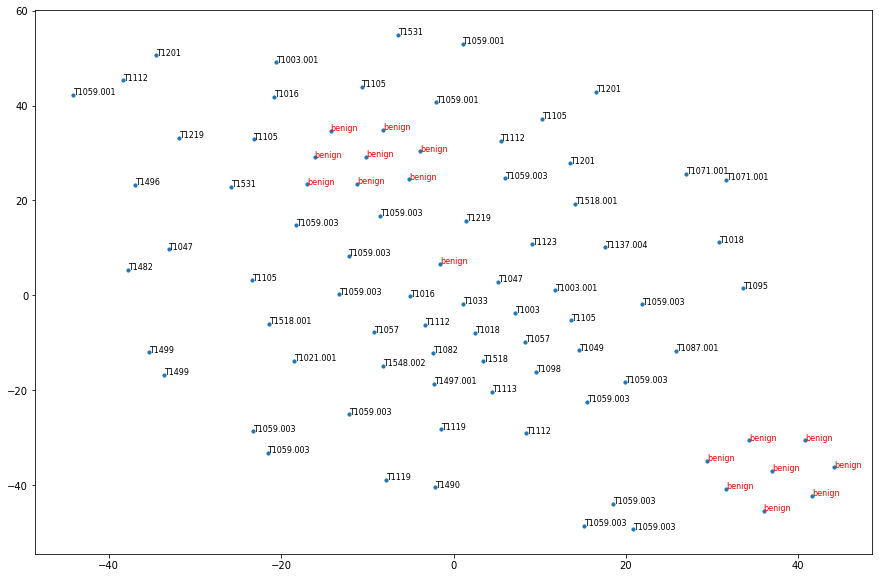

In [23]:
plt.figure(figsize=(15,10))
plt.scatter(compress_embedding[:,0],compress_embedding[:,1],s=10)
for idx,(x,y,key) in enumerate(zip(compress_embedding[:,0],compress_embedding[:,1],keys)):
    # plt.text(x,y,','.join([str(idx),key]),ha='left',rotation=0,c='black' if key == 'malicious' else 'red',fontsize=8)
    plt.text(x,y,key,ha='left',rotation=0,c='black' if key != 'benign' else 'red',fontsize=8)
plt.show()